# Travaux Pratiques - N9EE39A Edge Computing







**Contact: Adrien THIRION ([email](adrien.thir@gmail.com))**  







**Créé en Octobre 2023**















L'objectif de ces séances de travaux pratiques est de vous familiariser avec le métier de Data Scientists, plus particulièrement dans un environnement contraint (système embarqué). Celui-ci a été pensé pour développer une vue d'ensemble de toutes les étapes nécessaires lors de la création d'un modèle, jusqu'à ce que celui-ci soit embarqué.















Comme tout bon data scientist, l'utilisation de fonction existante sur internet est **vitale** !! En effet, l'intelligence artificielle est très présent de nos jours, donc si vous avez un problème, il est presque assuré que quelqu'un ait déjà eu le même !















Le TP va se porter sur un sujet concret: la reconnaissance vocal. Ce sujet rentre dans le thème du Traitement automatique du langage naturel ou NLP [[1]](https://en.wikipedia.org/wiki/Natural_language_processing)) où la demande en IA embarqué est très recherchée (ex. enceinte connecté, smartphone, smartwatches, ..). Pour cela, vous allez vous baser sur une base de données existante se trouvant Kaggle: the TensorFlow Speech Recognition Challenge. Kaggle est un site de competition permettant de récompenser les meilleurs modèles avec des prix décernés aux meilleurs modèles. Cette compétition a été organisée par Google, avec plus de 25 000$ à gagner. Certaines peuvent même dépasser le million de dollard (ex. Netflix Price) donc si vous avez soif d'argent ou que le l'IA vous plaît, allez y jeter un coup d'oeil !















Dans ce projet, vous allez essayer de classer correctement les 12 labels présents dans cette base de donnée via un modèle de convolution 1D ou récursif que vous aurez optimisé. Puis, vous devrez visualiser la variation des performances de ce modèle en fonction de son allégement (dans une volonté de l'embarquer).















Le Rapport devra être fait sur ce jupyter notebook, en Markdown (comme le texte que vous êtes en train de lire).















Ce projet a pour but d'évaluer votre esprit critique, votre analyse d'un problème et votre regard critique sur vos performances. Pour cela, l'entraide est encouragée mais en aucun cas le plagiat. Merci de respecter cela (promis c'est pour votre bien). Expliquez bien votre démarche et la raison de vos choix !!















Le projet sera découpé en 5 TPs de 4h. Un guide de progession sera affiché sur chaque partie pour connaître votre avancement.























Ce projet va être découpé en plusieurs parties:























1. L'Analyse de la base de donnée.







1. L'état de l'art.







1. Le Preprocessing.







1. L'apprentissage du modèle.







1. Les résultats et discussions.







1. L'allégement du modèle.







1. La conclusion.

## Analyse de la base de donnée























La première étape est de télecharger et d'analyser la base de donnée. Pour cela rendez vous sur le site de la compétition:  







https://www.kaggle.com/competitions/tensorflow-speech-recognition-challenge/overview















Pensez à bien regarder la compétition en détail, cela pourra vous être très utile (comme par exemple trouver du code ou des articles).















&nbsp;















<font color="Darkred"> Progression du TP après cette partie (environ 2h): </font>  

### Information sur la base de donnée







<font color=" Darkblue"> **Tips:** Parlez de tous ce que vous savez des données (quantité d'instances, les labels, la taille d'une time series, sa fréquence d'echantillonage, ...). </font>















Fréquence d'échantillonnage : 16kHz







Quantité d'instances : 64727







Nombre de labels : 12 (unkown étant composés de plusieurs labels non reconnus)







Taille d'une time series : 1 seconde (16000 points)










### Visualitation d'une donnée et analyse critique







<font color=" Darkblue"> **Tips:** Faites un subplot de plusieurs labels différents pour voir visuellement les différences. </font>















> **Ecrire votre texte ici.**

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import IPython.display as ipd
from scipy.io import wavfile
from google.colab import drive # Pour google colab
from tqdm import tqdm # Pour afficher une barre de progression
drive.mount('/content/drive')  # Pour google colab

# Ajouter ce dossier dans votre drive: https://drive.google.com/drive/folders/1AAiaDTWJzvS6NaZXE_dfJ603QWhhcl0R?usp=sharing

Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/tensorflow-speech-recognition-challenge-20241127T174321Z-001.zip /content/tensorflow-speech-recognition-challenge.zip
!unzip -q tensorflow-speech-recognition-challenge.zip
!rm -rf tensorflow-speech-recognition-challenge.zip

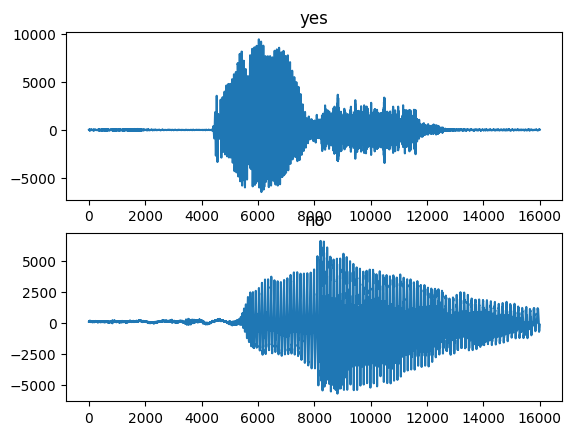

In [3]:
#subplot sur plusieurs classes :
list_labels = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown']
sample_rate, samples = wavfile.read('/content/tensorflow-speech-recognition-challenge/train/audio/yes/0a7c2a8d_nohash_0.wav')
sample_rate2, samples2 = wavfile.read('/content/tensorflow-speech-recognition-challenge/train/audio/no/0a9f9af7_nohash_0.wav')



plt.subplot(2, 1, 1)
plt.plot(samples)
plt.title('yes')
plt.subplot(2, 1, 2)
plt.plot(samples2)
plt.title('no')
plt.show()


In [4]:
# Exporter une donnée

sample_rate, time_series = wavfile.read('/content/tensorflow-speech-recognition-challenge/train/audio/bird/00b01445_nohash_0.wav')

# Ecouter la donnée
ipd.Audio(time_series, rate=sample_rate)

### Stockage des données







 <font color="red"> **ATTENTION:** Respectez l'ordre des labels: 0 = yes, 1 = no, 2 = up, 3 = down, 4 = left, 5 = right, 6 = on, 7 = off, 8 = stop, 9 = go, 10 = silence, 11 = unknown </font>















<font color=" Darkblue"> **Tips:** Réduisez la taille des données d'entrées afin d'éviter la saturation de la mémoire </font>

In [5]:
import os



def fix_length(samples, length=16000):
    if len(samples) > length:
        start_ind = tf.random.uniform([1], maxval=len(samples)-length, dtype=tf.int32)[0]
        samples = samples[start_ind:start_ind+length]
    elif len(samples) < length:
        samples = tf.concat([samples, tf.zeros([length - len(samples),1])], axis=0)
    return samples



def import_data():
    all_waves, all_labels = [], []
    excluded_labels = [ 'happy', 'wow', 'marvin', '_background_noise_' ]
    recognized_labels = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence']
    for label in recognized_labels:
        print("Importing label: ", label)
        if label == 'silence':
            label_dir = '/content/tensorflow-speech-recognition-challenge/train/audio/_background_noise_'
            waves = [f'{label_dir}/{f}' for f in os.listdir(f'{label_dir}') if f.endswith('.wav')]
            all_waves = all_waves + waves
            all_labels = all_labels + [list_labels.index(label)]*len(waves)
        else:
            label_dir = f'/content/tensorflow-speech-recognition-challenge/train/audio/{label}'
            waves = [f'{label_dir}/{f}' for f in os.listdir(f'{label_dir}') if f.endswith('.wav')]
            all_waves = all_waves + waves
            all_labels = all_labels + [list_labels.index(label)]*len(waves)

    #add some unknown labels
    unknown_labels = [label for label in os.listdir('/content/tensorflow-speech-recognition-challenge/train/audio') if label not in recognized_labels and label not in [".DS_Store"] and label not in excluded_labels]

    for label in unknown_labels:
        print("Importing samples from unknown label: ", label)
        waves = [f'{label_dir}/{f}' for f in os.listdir(f'/content/tensorflow-speech-recognition-challenge/train/audio/{label}') if f.endswith('.wav')]
        all_waves = all_waves + waves
        all_labels = all_labels + [list_labels.index('unknown')]*len(waves)
    return np.array(all_waves), np.array(all_labels)

all_waves, all_labels = import_data()

Importing label:  yes
Importing label:  no
Importing label:  up
Importing label:  down
Importing label:  left
Importing label:  right
Importing label:  on
Importing label:  off
Importing label:  stop
Importing label:  go
Importing label:  silence
Importing samples from unknown label:  three
Importing samples from unknown label:  two
Importing samples from unknown label:  six
Importing samples from unknown label:  house
Importing samples from unknown label:  four
Importing samples from unknown label:  nine
Importing samples from unknown label:  five
Importing samples from unknown label:  zero
Importing samples from unknown label:  bird
Importing samples from unknown label:  cat
Importing samples from unknown label:  sheila
Importing samples from unknown label:  dog
Importing samples from unknown label:  bed
Importing samples from unknown label:  seven
Importing samples from unknown label:  one
Importing samples from unknown label:  eight
Importing samples from unknown label:  tree


## Etat de l'art
Etape importante qui suit: faire un état de l'art. Que cela soit pour innover, ou pour trouver une solution existante pertinente, faire un état de l'art scientifique est essentiel. Ici, vous devez chercher les articles liés à ce projet. Il faut pour cela remplir le tableau et bien marquer leurs références en dessous. De plus, un texte synthétique vous sera demandé pour expliquer selon vous, quels papiers sont les plus pertinants pour la suite de ce projet.

Attention: une analyse critique est nécessaire sur ces papiers (certain papiers peuvent avoir des biais cachés).

<font color="orange"> **Note anti-plagiat:** Au moins 2 références devraient être différente des autres binômes. </font>

<font color="Red"> Progression du TP après cette partie (environ 2h):

> **Ecrire votre texte ici.**

| References | Preprocessing | Modèle |  Solution Embarquée ? | Dataset utilisé | Performances | Lien | Note |
| :---------------- | :------: | :----: | :----: | :----: | :----: |:----:| :----: |
| MatchboxNet 2020 1D CNN | pas vue |  MatchboxNet | Non (77k param)| Google Speech Commands v1 | 97% | https://arxiv.org/pdf/2004.08531v2 | 5/5 |
| TRAINING WITH LIMITED DATA | ?  |  pre-trained ”Embedding+Head” Model | oui| speech commands |  97.4% | https://arxiv.org/pdf/2002.01322 | 3/5 |
| Attention model 2018 | pas vue |   Attention RNN | Non (77k param)| Google Speech Commands dataset V1 |  94.1% | https://arxiv.org/pdf/2004.08531v2 | - |
| A CompactkRNN for Edge Computin2020g | MFCC | EdgeRNN-G | oui sur Raspberry Pi +3B | Google Speech Commands dataset V1 | 96.62% | https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9081948 | 4/5 si freq|
| Acceleration for Speech-Classification in Edge-Computing| MFCC + random time shifting up to 20%| CASENet1-L (CNN) | oui | Google Speech Commands dataset V1 | 95.4% | https://ieeexplore.ieee.org/document/9658881 | 5/5|
| E2E From the Raw Waveform | - | E2E | Non | Google Speech Commands dataset V1 | 95.4% | https://arxiv.org/pdf/1806.07098 | 2/5
| Avantage de la fusion cnn+rnn  | - | CRNN | OUI microP | TalkType + Alexa | 87.8% | https://arxiv.org/pdf/1711.07128v3 | 3/5
| Data set | Google Speech Commands dataset V1| https://arxiv.org/pdf/1804.03209
| Edge computing method| TinyML| https://arxiv.org/pdf/1804.03209 | 4/5 |

#### Références:
- [1]: toto et al., .....

## Preprocessing















C'est la partie la plus importante du projet !! Même le modèle le plus performant de la terre ne pourra pas être précis sans des données d'entrées propres. De plus, il est important de réduire la quantité de données d'entrée (Décimation) afin de ne pas avoir un modèle trop lourd.















<font color=" Darkblue"> **Tips:** Commencez par un preprocessing simple, et améliorez le lorsque les modèles seront en cours d'apprentissage. </font>















Voici quelques sources qui pourront vous être utile pour faire votre code, en plus de l'état de l'art précedemment fait:







- https://medium.com/enjoy-algorithm/pre-processing-of-time-series-data-c50f8a3e7a98







- https://monkeylearn.com/blog/data-preprocessing/







- https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/







- https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html (pour les plus expérimenté d'entre vous)















&nbsp;















<font color=" Darkred"> Progression du TP après cette partie (environ 3h): </font>  







![56%](https://progress-bar.dev/56)


### Zone d'expérimentation















Ici vous êtes libre d'essayer des choses, les visualiser, avoir un regard critique sur la solution que vous décidez de prendre. Utilisez autant de cases de codes et de textes.

### Fonction de preprocessing















> **Ecrire votre texte ici.**

In [40]:
import tensorflow as tf

def preprocessing(inputs):
    # Read and preprocess each input
    for i in range(inputs.shape[0]):
        audio, sample_rate = tf.audio.decode_wav(tf.io.read_file(inputs[i]),1,16000)  # Decode WAV file
        audio = fix_length(audio)

    clean_inputs = audio

    # Calculate mean along the batch axis
    mean = tf.reduce_mean(clean_inputs, axis=0, keepdims=True)
    centered = clean_inputs - mean

    # Normalize
    min_val = tf.reduce_min(centered, axis=0, keepdims=True)
    max_val = tf.reduce_max(centered, axis=0, keepdims=True)
    normalized = (centered - min_val) / (max_val - min_val + 1e-5)

    # Decimation: Keep only indices where `i % 4 != 0`
    indices = tf.range(tf.shape(normalized)[0])  # Generate index range
    mask = tf.not_equal(indices % 2, 0)  # Boolean mask for indices not divisible by 4
    decimated = tf.boolean_mask(normalized, mask, axis=0)
    sample_rate = sample_rate/2

    decimated = tf.squeeze(decimated)
    return decimated

print(f'Input before preprocessing: {all_waves.shape}')
#print(f'Input after preprocessing: {preprocessing(all_waves).shape}')


Input before preprocessing: (59509,)


## Apprentissage du Modèle







On y est, il est temps de créer un modèle. Pour cela, il vous sera imposé d'utiliser un réseau de convolution 1D [2] (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D). Nous préconisons l'utilisation de Tensorflow mais vous êtes libre d'utiliser d'autres librairies comme Pytorch.















&nbsp;















<font color=" Darkred"> Progression du TP après cette partie (environ 3h): </font>  







![75%](https://progress-bar.dev/75)

### Train set, Validation set















Avant d'entraîner votre modèle, pensez à séparer vos données d'entraînements et vos données de validations. Puis, pensez à créer des batchs pour correspondre à l'entrée de votre modèle.















Plus d'infos ici:







 - https://www.tensorflow.org/datasets/splits?hl=fr







 - https://towardsdatascience.com/how-to-split-a-dataframe-into-train-and-test-set-with-python-eaa1630ca7b3







 - https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough?hl=fr















 <font color=" Darkblue"> **Tips:** Pensez à bien mélanger vos données avant de les séparer. </font>















 <font color="orange"> **Note anti-plagiat:** Le mélange doit avoir une random seed fixe et différente pour chaque groupe. </font>

In [41]:

from sklearn.model_selection import train_test_split

BATCH_SIZE = 256 #Vous pouvez le modifier
np.random.seed(618463)
TRAIN_RATE = 80
Train_indx=int(all_waves.shape[0]*TRAIN_RATE/100)

# TO DO: Séparez vos données.
X_train, y_train = all_waves[:Train_indx], all_labels[:Train_indx]
X_val, y_val = all_waves[Train_indx:], all_labels[Train_indx:]
y_train = tf.keras.utils.to_categorical(y_train, num_classes=12)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=12)
X_train = np.expand_dims(X_train, axis=-1)
train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().shuffle(buffer_size=10000).map(lambda x,y: (preprocessing(x),y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
train = train.batch(BATCH_SIZE, drop_remainder=True)
X_val = np.expand_dims(X_val, axis=-1)
val = tf.data.Dataset.from_tensor_slices((X_val, y_val)).cache().map(lambda x,y: (preprocessing(x),y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val = val.batch(BATCH_SIZE, drop_remainder=True)

for example_inputs, example_labels in train.take(1):
    print(example_inputs.shape)
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

(256, 8000)
Inputs shape (batch, time, features): (256, 8000)
Labels shape (batch, time, features): (256, 12)


In [42]:
ipd.display(ipd.Audio(example_inputs[8,:,0], rate=8000))
list_labels = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown']
for i in range(12):
  if example_labels[8][i] == 1:
    print(f'label is {list_labels[i]}')

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/

### Baseline















La baseline est importante afin de connaître le seuil où le modèle est performant. A vous de trouver la meilleure baseline et d'expliquer votre choix.















Plus d'infos ici:







https://towardsdatascience.com/calculating-a-baseline-accuracy-for-a-classification-model-a4b342ceb88f















> **Ecrire votre texte ici.**

In [31]:
# TO DO
from collections import Counter
result_train = Counter(all_labels[:Train_indx]).most_common(1)[0][1]/len(y_train)
result_val = Counter(all_labels[Train_indx:]).most_common(1)[0][1]/len(y_val)
print(f'Train dataset: {result_train}%')
print(f'Validation dataset: {result_val}%')

Train dataset: 0.5021110340916252%
Validation dataset: 1.0%


### Modèle















Vous devez créer une fonction permettant de générer le modèle. Celle-ci doit pouvoir être modifiable en fonction des Hyperparamètres mis en entrée.















 <font color="red"> **ATTENTION:** Une limite de 150 000 paramètres est imposés. </font>















Justification de vos choix (Choix des paramètres modifiables, fonction d'activations, nombres de couches, regularizers, ...) :







> **Ecrire votre texte ici.**

In [47]:
from tensorflow.keras import layers

def total_param(model):
# Ne pas modifier.
  stringlist = []
  model.summary(print_fn=lambda x: stringlist.append(x))
  for line in stringlist[::-1]:
    if "Total params" in line:
      value = line.split('(')[1]
      if value[-3:-1] == 'KB':
        return float(value[:-4]) * 1e3
      else:
        return float(value[:-4]) * 1e6

class Bloc_RNN(tf.keras.Model):
    def __init__(self, filters, kernel_size, dropout_rate):
        super(Bloc_RNN, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.dropout_rate = dropout_rate

        # Main model
        self.model = tf.keras.Sequential([
            layers.DepthwiseConv1D(kernel_size=self.kernel_size, padding="same"),
            layers.Conv1D(self.filters, kernel_size=1, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dropout(self.dropout_rate),
            layers.DepthwiseConv1D(kernel_size=self.kernel_size, padding="same"),
            layers.Conv1D(self.filters, kernel_size=1, padding="same"),
            layers.BatchNormalization()
        ])

        # Shortcut connection
        self.sidemodel = tf.keras.Sequential([
            layers.Conv1D(self.filters, kernel_size=1, padding="same"),
            layers.BatchNormalization()
        ])

        # Output model
        self.outmodel = tf.keras.Sequential([
            layers.ReLU(),
            layers.Dropout(self.dropout_rate)
        ])

    def call(self, x):
        shortcut = self.sidemodel(x)
        x = self.model(x)
        x += shortcut
        return self.outmodel(x)


def create_model(param):
  # Exemple à modifier
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(8000,1)))
  model.add(tf.keras.layers.MelSpectrogram(num_mel_bins=80,sampling_rate=8000,sequence_stride=128,fft_length=2048))
  model.add(tf.keras.layers.Conv1D(8, 7, strides=10, activation=param['activation']))
  for i in range(param['hidden_layer']):
    model.add(Bloc_RNN(64,3,0.2))
  model.add(tf.keras.layers.Dense(12, activation='softmax'))
  return model

param = {
    # Exemple de paramètres à modifier
    'activation' : 'relu',
    'hidden_layer' : 3}

model = create_model(param)
model.summary()
print(f'Poids du modèle: {total_param(model)} octets')

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mel_spectrogram_4 (MelSpectrogram)   │ (None, 80, 63)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 8, 8)                │           3,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bloc_rnn_1 (Bloc_RNN)                │ (None, 8, 64)               │           6,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bloc_rnn_2 (Bloc_RNN)                │ (None, 8, 64)               │          13,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bloc_rnn_3 (Bloc_RNN)                │ (None, 8, 64)               │          13,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8, 12)               │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,204 (149.23 KB)

 Trainable params: 37,052 (144.73 KB)

 Non-trainable params: 1,152 (4.50 KB)

ValueError: could not convert string to float: 'type)                         ┃ Output Shape                ┃         Param # ┃\n┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩\n│ mel_spectrogra'

### Fonction d'entraînement















Cette fonction doit prendre un modèle en entrée et l'entrainer grâce au Train set. Puis, retourner les performances obtenues avec le Validation set.















Pour les plus expérimentés d'entre vous: Vous pouvez réaliser une cross validation [[2]](https://datascientest.com/cross-validation).















Justification de vos choix (Choix des paramètres modifiables, optimizer, nombres d'epoch, learning rate, ...) :







> **Ecrire votre texte ici.**

In [ ]:
%load_ext tensorboard
!mkdir logs
%tensorboard --logdir='/content/logs'

In [36]:
for x,y in tqdm(train.take(1)):
  print(x.shape)
  continue

100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

(256, 8000)


In [48]:
def compile_and_fit(model, train, val, param, verbose=1):
    # Exemple à modifier
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=0.2,
                                                    mode='min')
    # Pour les plus confirmés
    # lr = tf.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate=1e-2,
    #     decay_steps=1000,
    #     decay_rate=0.95)
    lr =  1e-3

    model.compile(loss='categorical_crossentropy',
                optimizer=tf.optimizers.Adam(learning_rate=lr),
                metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
    model.fit(train, epochs=param['max_epochs'],
                      validation_data=val,
                      callbacks=[early_stopping,tf.keras.callbacks.TensorBoard(log_dir = '/content/logs',histogram_freq = 1,profile_batch = '0,2')], verbose=verbose)
    validation_accuracy = model.evaluate(val)
    return validation_accuracy, model

param = {
    # Exemple de paramètres à modifier
    'max_epochs' : 1000
}
validation_accuracy = compile_and_fit(model, train, val, param)

Epoch 1/1000


InvalidArgumentError: Exception encountered when calling MelSpectrogram.call().

[1m{{function_node __wrapped__MirrorPad_device_/job:localhost/replica:0/task:0/device:GPU:0}} paddings must be less than the dimension size: 1024, 1024 not less than 1 [Op:MirrorPad][0m

Arguments received by MelSpectrogram.call():
  • inputs=tf.Tensor(shape=(256, 8000, 1), dtype=float32)

### Fit tuning des hyperparamètres.















Après avoir défini les hyperparamètres modifiables et vérifier que les fonctions fonctionnent, il est temps de lancer l'optimisation des hyperparamètres. Pour cela je vous invite à utiliser Optuna [[3]](https://optuna.readthedocs.io/en/stable/index.html) qui a plusieurs fonctionnalités:







*   Une visualisation facilitée.







*   Un suivi de l'avancement de l'optimisation.







*   Une possibilité de reprendre l'optimisation sans reprendre depuis le début si un problème arrive durant le traitement.















 <font color=" Darkblue"> **Tips:** Essayez de lancer l'optimisation pendant le TP pour voir si il fonctionne et arretez le. Lancez le pour de bon à la fin de la séance ou pendant la semaine car cela va prendre plusieurs heures, voir plusieurs jours. </font>















 <font color="orange"> **Note anti-plagiat:** L'optimisation doit avoir une random seed fixe et différente pour chaque groupe. </font>















 Merci de justifier vos plages de valeurs et faite un résumé sous forme de tableau :







 > **Ecrire votre texte ici.**























 | Hyperparamètre | Meilleure valeur | Plage | Step | Type de la plage |







| :---------------- | :------: | :----: | :----: | :----: |







| -   |  -  | - | - | - |

In [ ]:
!pip install optuna

import optuna
SEED = 5
np.random.seed(SEED)

def objective(trial):
    # Exemple de paramètres à modifier
    param_model = {
        'activation': trial.suggest_categorical("activation", ["relu", "selu"]),
        'hidden_layer' : trial.suggest_int('hidden_layer', 1, 3)
    }
    param_training = {
        'max_epochs': trial.suggest_int('max_epochs', 800, 1000, step=100),
    }
    model = create_model(param_model)
    metrics, _ = compile_and_fit(model, train, val, param_training, verbose=0)
    trial.set_user_attr('Size', total_param(model))
    return metrics[1]

study_name = "NOM1~NOM2-Tuning"
storage_name = f'sqlite:////content/drive/MyDrive/TP N9EE39A/{study_name}.db' #Chemin à créer dans votre drive
study = optuna.create_study(
    direction='maximize',
    study_name=study_name,
    storage=storage_name,
    sampler=optuna.samplers.TPESampler(seed=SEED),
    load_if_exists=True)

study.optimize(objective, n_trials=2)

## Résultat et discussion















<font color=" Darkred"> Progression du TP après cette partie (environ 3h): </font>  







![84%](https://progress-bar.dev/84)


### Export du modèle















Merci d'exporter le meilleur modèle et l'envoyer avec le jupyter notebook et la base de données d'entraînement. Lors de l'exportation d'un modèle, il est recommandé d'utiliser la base de donnée d'entrainement, et de validation.















 <font color="green">*Cette partie du code est complète, vous n'avez pas besoin de la modifier.* </font>

In [ ]:
import joblib
study = optuna.load_study(storage=storage_name, study_name=study_name)
print("Best trial until now:")
print("   Value: ", study.best_trial.value)
print("   Params: ")
for key, value in study.best_trial.params.items():
    print(f"    -{key}: {value}")
print("----------------------")
model = create_model(study.best_trial.params)
train_and_val = tf.data.Dataset.from_tensor_slices((np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val))))
train_and_val = train_and_val.shuffle(1500, reshuffle_each_iteration=True)
train_and_val = train_and_val.batch(32, drop_remainder=True)
_, global_model = compile_and_fit(model, train_and_val, val, study.best_trial.params, verbose=0)
joblib.dump(global_model, '/content/drive/MyDrive/TP N9EE39A/NOM1~NOM2_model.pkl')

### Dépôt sur Kaggle















Il est temps de soumettre vos résultats sur Kaggle. Qu'en pensez vous, êtes vous satisfait de vos performances ? Est-ce que vous vous attendiez à ces performances ?















 <font color=" Darkblue"> **Tips:** Le format d'envoie et des tutoriels sont disponibles sur la page du concours. </font>















 <font color="orange"> **Note anti-plagiat:** Il est impossible que le fichier que vous allez déposer soit le même qu'un autre binôme. Le fichier sera regénérer lors de la correction et doit être similaire avec celui déposé. </font>















A la fin du projet, merci d'envoyer avec les autres fichiers ce fichier Kaggle avec comme nom **NOM1~NOM2_submission.csv**.















> **Ecrire votre texte ici.**

In [ ]:
#Ici, tous le code est à faire. Normalement, tous a déjà été codé ou est facilement trouvable sur internet et sur le site de la compétition !

### Visualisation des résultats















Ici tous le code a déjà été fait. Il faut par contre commenter les résultats et les performances que vous avez obtenu et l'utilité de chaque figure.

 #### Matrice de confusion















 <font color="green">*Cette partie du code est complète, vous n'avez pas besoin de la modifier.* </font>















 > **Ecrire votre texte ici.**

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
study = optuna.load_study(storage=storage_name, study_name=study_name)
model = create_model(study.best_trial.params)
_, model = compile_and_fit(model, train, val, study.best_trial.params, verbose=0)
y_prob= model.predict(val)
y_pred = y_prob.argmax(axis=1)
ds_labels=[]
for images, labels in val.unbatch():
    ds_labels.append(labels)
y_ref = np.array(ds_labels).argmax(axis=1)

label_names = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence", "unknown"]
ConfusionMatrixDisplay.from_predictions(y_ref, y_pred, cmap='Blues', normalize='true', ax=plt.subplots(figsize=(12,12))[1], display_labels=label_names)

#### Résultat du Fit-tuning















 <font color="green">*Cette partie du code est complète, vous n'avez pas besoin de la modifier.* </font>















 > **Ecrire votre texte ici.**

In [ ]:
plt.figure(figsize=(12,12))
optuna.visualization.plot_optimization_history(study)

In [ ]:
plt.figure(figsize=(12,12))
optuna.visualization.plot_slice(study)

#### Influence des hyperparamètres sur les performances















 <font color="green">*Cette partie du code est complète, vous n'avez pas besoin de la modifier.* </font>















 > **Ecrire votre texte ici.**

In [ ]:
result = optuna.importance.get_param_importances(study)
plt.figure(figsize=(12, 4.5), dpi=100)
names = list(result.keys())
values = list(result.values())
plt.bar(range(len(result)), np.array(values)*100, tick_label=names, color='#000233')
plt.ylabel("Hyperparameter importance (%)")
plt.show()

#### Influence des hyperparamètres sur le temps de calcul















 <font color="green">*Cette partie du code est complète, vous n'avez pas besoin de la modifier.* </font>















 > **Ecrire votre texte ici.**

In [ ]:
result = optuna.importance.get_param_importances(study, target=lambda t: t.duration.total_seconds())
plt.figure(figsize=(12, 4.5), dpi=100)
names = list(result.keys())
values = list(result.values())
plt.bar(range(len(result)), np.array(values)*100, tick_label=names, color='#000233')
plt.ylabel("Hyperparameter importance (%)")
plt.show()

#### Frontière de Pareto [[4]](https://fr.wikipedia.org/wiki/Optimum_de_Pareto)















 <font color="green">*Cette partie du code est complète, vous n'avez pas besoin de la modifier.* </font>















 > **Ecrire votre texte ici.**

In [ ]:
import pandas

def plot_pareto_frontier(Xs, Ys, maxX=True, maxY=True):
  # From https://sirinnes.wordpress.com/2013/04/25/pareto-frontier-graphic-via-python/
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
    '''Plotting process'''
    plt.scatter(Xs,Ys)
    pf_X = [pair[0] for pair in pareto_front]
    pf_Y = [pair[1] for pair in pareto_front]
    plt.plot(pf_X, pf_Y)
    plt.xlabel("Poids du modèle (octets)")
    plt.ylabel("Accuracy (%)")
    plt.show()
df = study.trials_dataframe()
plot_pareto_frontier(df['user_attrs_Size'], df['value'])

## Allégement du modèle post-optimisation















Dans cette dernière partie, nous allons nous intéresser à l'influence des performances lorsque le modèle est allégé. Dans des appareils embarqués, il est nécessaire de trouver un compromis entre la performance du modèle, son poids, et la quantité d'opération.















Au vue du nombre de séances, nous allons nous intéressé ici qu'au poids du système.















Pour cela, vous allez essayé de réduire le poids du meilleur modèle obtenu, puis avoir un regard critique sur les performances à chaque modification.















Voici les techniques d'allégement à essayer:







  - **La quantification**: Réduire le nombre d'octets des paramètres du modèles et les convertir en entiers [[5]](https://www.tensorflow.org/lite/performance/post_training_quantization).







  - **L'élagage**: Supprimer les modèles qui ont un impact mineur sur les prédictions [[6]](https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras).







  - **Le clustering**: Regrouper les poids de chaque couche dans un modèle en un nombre prédéfini de clusters, puis en partageant les valeurs centroïdes pour les poids appartenant à chaque cluster individuel [[7]](https://www.tensorflow.org/model_optimization/guide/clustering/clustering_example).







  - **La décimation** : Réduire le nombre d'entrée.















<font color=" Darkred"> Progression du TP après cette partie (environ 4h):















Essayez d'avoir la meilleure accuracy avec un poids maximum inférieur à 75 KB.















 <font color=" Darkblue"> **Tips:**  Des tutoriels sont disponibles sur les liens attachés au techniques d'allégement. </font>















 > **Ecrire votre texte ici.**

In [ ]:
#Ici, tous le code est à faire. Normalement, tous a déjà été codé ou est facilement trouvable sur internet !

### BONUS: Allégement avant optimisation















Relancez un fit-tuning en rajoutant les paramètres d'allégements. Puis, observez les resultats avec une frontière de pareto. Les valeurs minimums de poids de la frontière doivent se trouver en dessous de 50 KB.















 <font color=" Darkblue"> **Tips:** Utilisez 2 métriques lorsque vous lancez la fonction d'activation. </font>















 > **Ecrire votre texte ici.**

## Conclusion























 <font color=" Darkblue"> **Tips:** Concluez sur vos résultats, les limitations de votre modèle et les perspectives envisagées pour l'améliorer. </font>























 <font color=" Darkred"> Progression du TP après cette partie (environ 0h30): </font>  























> **Ecrire votre texte ici.**